# (29) Combine neural fits

**Motivation**: ...across different sim categories & analyze <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-MTMST/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-MTMST/figs')
tmp_dir = os.path.join(git_dir, 'jb-MTMST/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_MTMST'))
from vae.train_vae import TrainerVAE, ConfigTrainVAE
from vae.vae2d import VAE, ConfigVAE
from figures.fighelper import *
from analysis.glm import *


# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

In [2]:
# HIDE CODE


def best_results(df, categories: List[str] = None):
    if categories is None:
        categories = df['category'].unique()
    df_best = collections.defaultdict(list)
    for expt in df['expt'].unique():
        _df1 = df.loc[
            (df['expt'] == expt) &
            (df['category'].isin(categories))
        ]
        for cell in _df1['cell'].unique():
            _df2 = _df1.loc[_df1['cell'] == cell]
            best_i = _df2['perf'].argmax()
            best = dict(_df2.iloc[best_i])

            _max = best.pop('perf')
            _min = _df2['perf'].min()
            mu = _df2['perf'].mean()
            sd = _df2['perf'].std()

            best['perf_best'] = _max
            best['perf_worst'] = _min
            best['perf_mu'] = mu
            best['perf_sd'] = sd
            best['%+'] = 100 * (_max - mu) / mu
            best['%-'] = 100 * (_min - mu) / mu

            for k, v in best.items():
                df_best[k].append(v)
    df_best = pd.DataFrame(df_best)
    return df_best

## Copy fits to tmp dir

In [3]:
fits = [
    'fixate0_nf-80_(2023_04_28,22:46)',
    'fixate1_nf-420_(2023_04_27,20:20)',
    'fixate2_nf-420_(2023_04_27,13:57)',
    # 'fixate2_nf-420_(2023_04_28,12:46)', # local to GABAN, currently not used
    'fixate4_nf-420_(2023_04_28,16:15)',
    'fixate8_nf-420_(2023_04_28,14:34)',

    'transl0_nf-70_(2023_04_27,13:30)',
    'transl1_nf-420_(2023_04_27,13:00)',
    'transl2_nf-420_(2023_04_27,19:16)',
    'transl4_nf-420_(2023_04_27,07:52)',
    # TODO: transl8,
    
    'Medium_obj1_nf-280_(2023_04_26,15:53)',
    'obj4_nf-280_(2023_04_26,18:21)',
    'obj8_nf-420_(2023_04_28,12:48)',
    
    'terrain1_nf-210_(2023_04_27,12:50)',
    'terrain2_nf-420_(2023_04_28,15:15)',
    'terrain4_nf-420_(2023_04_28,14:08)',
    'terrain8_nf-420_(2023_04_26,22:51)',
]
copy_fits(fits, pjoin(tmp_dir, 'results_combined'))

## Load & analyze

In [4]:
df = []
perf = {}
for fit_name in fits:
    _df = f"summary_{fit_name}.df"
    _df = pjoin(tmp_dir, 'results_combined', _df)
    _df = pd.read_pickle(_df)
    k = _df['category'].unique().item()
    perf[k] = _df.perf.values
    df.append(_df)
df = pd.concat(df)
print({k: len(v) for k, v in perf.items()})

{
    'fixate0': 141,
    'fixate1': 141,
    'fixate2': 141,
    'fixate4': 141,
    'fixate8': 141,
    'transl0': 141,
    'transl1': 141,
    'transl2': 141,
    'transl4': 141,
    'obj1': 141,
    'obj4': 141,
    'obj8': 141,
    'terrain1': 141,
    'terrain2': 141,
    'terrain4': 141,
    'terrain8': 141
}

In [5]:
grouped_by_cat = collections.defaultdict(list)
grouped_by_nobj = collections.defaultdict(list)
for sim in df['category'].unique():
    cat, n = sim[:-1], int(sim[-1])
    grouped_by_cat[cat].append(n)
    grouped_by_nobj[n].append(cat)
grouped_by_cat = dict(grouped_by_cat)
grouped_by_nobj = dict(grouped_by_nobj)

print(grouped_by_cat)
print(grouped_by_nobj)

{
    'fixate': [0, 1, 2, 4, 8],
    'transl': [0, 1, 2, 4],
    'obj': [1, 4, 8],
    'terrain': [1, 2, 4, 8]
}

{
    0: ['fixate', 'transl'],
    1: ['fixate', 'transl', 'obj', 'terrain'],
    2: ['fixate', 'transl', 'terrain'],
    4: ['fixate', 'transl', 'obj', 'terrain'],
    8: ['fixate', 'obj', 'terrain']
}

In [6]:
pal = {}
colors = ['Blues', 'Oranges', 'Greens', 'Purples', 'Greys']
for c, (k, v) in zip(colors, grouped_by_cat.items()):
    _pal = sns.color_palette(c, n_colors=len(v) + 3)[1:-2]
    for i in range(len(v)):
        pal[f"{k}{v[i]}"] = _pal[i]

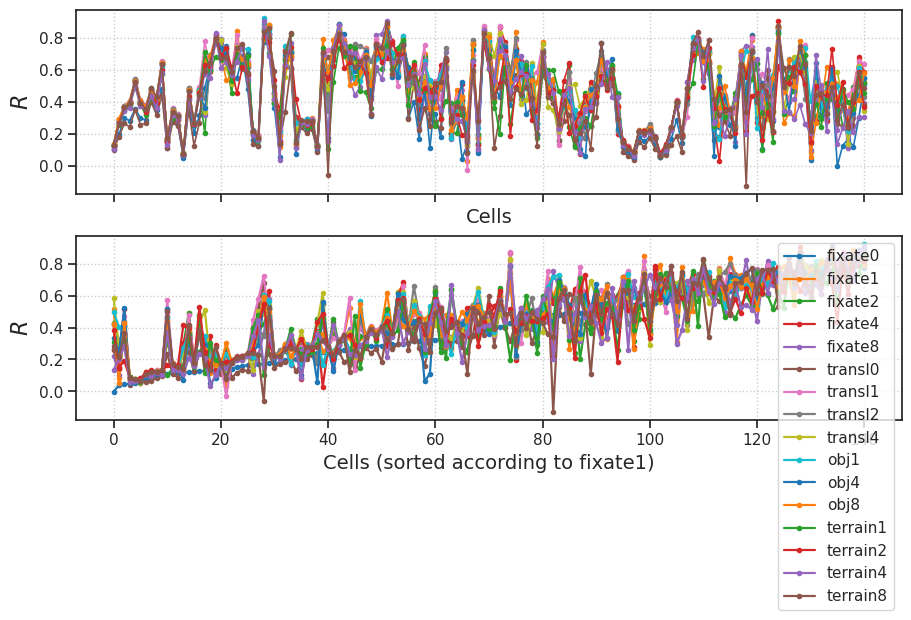

In [7]:
# HIDE CODE


sorted_data = sorted(
    zip(*(v for v in perf.values())),
    key=lambda x: x[0],
)
sorted_data = tuple(zip(*sorted_data))


fig, axes = create_figure(2, 1, (9, 6), 'all', layout='constrained')

for k, v in perf.items():
    axes[0].plot(v, marker='.', lw=1.2, label=k)
axes[0].set_xlabel('Cells', fontsize=14)

for k, v in zip(perf, sorted_data):
    axes[1].plot(v, marker='.', lw=1.6, label=k)
axes[1].set_xlabel('Cells (sorted according to fixate1)', fontsize=14)
axes[1].legend()

for ax in axes.flat:
    ax.set_ylabel(r'$R$', fontsize=16)
    ax.grid()

plt.show()

In [8]:
# HIDE CODE


x = np.stack([v for v in perf.values()])

counts = collections.Counter(np.argmax(x, axis=0))
counts = {
    list(perf)[i]: c for i, c
    in counts.most_common()
}
counts = {
    k: counts.get(k, 0) for k
    in list(counts) + list(perf)
}

percent = {
    k: np.round(100 * v / sum(counts.values()), 1)
    for k, v in counts.items()
}
print(percent)

{
    'transl1': 17.7,
    'fixate1': 12.8,
    'obj1': 8.5,
    'transl2': 7.8,
    'terrain2': 6.4,
    'transl4': 6.4,
    'fixate4': 6.4,
    'fixate8': 5.7,
    'terrain1': 5.7,
    'obj8': 5.0,
    'terrain8': 5.0,
    'terrain4': 3.5,
    'fixate2': 2.8,
    'fixate0': 2.1,
    'transl0': 2.1,
    'obj4': 2.1
}

In [9]:
best = x.max(0)
x = best.mean()
x

0.5692952952455489

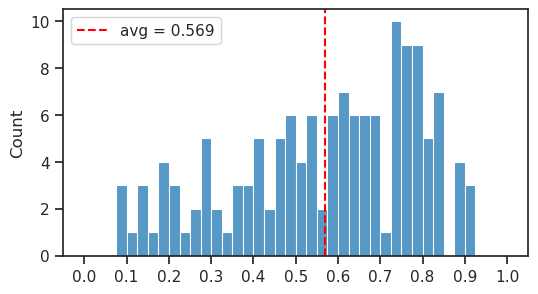

In [10]:
fig, ax = create_figure(1, 1, (6, 3.2))
sns.histplot(best, bins=np.linspace(0, 1, 41), ax=ax)
ax.axvline(x, color='r', ls='--', label=f"avg = {x:0.3f}")
ax.locator_params(axis='x', nbins=11)
ax.legend()
plt.show()

In [75]:
patrick = 100 * (569 - 251) / 251
res = 100 * (569 - 447) / 447

msg = f"outperforming patrick: {patrick:0.0f} %"
msg += f"\noutperforming reservoir: {res:0.0f} %"
print(msg)

outperforming patrick: 127 %
outperforming reservoir: 27 %

## More plots

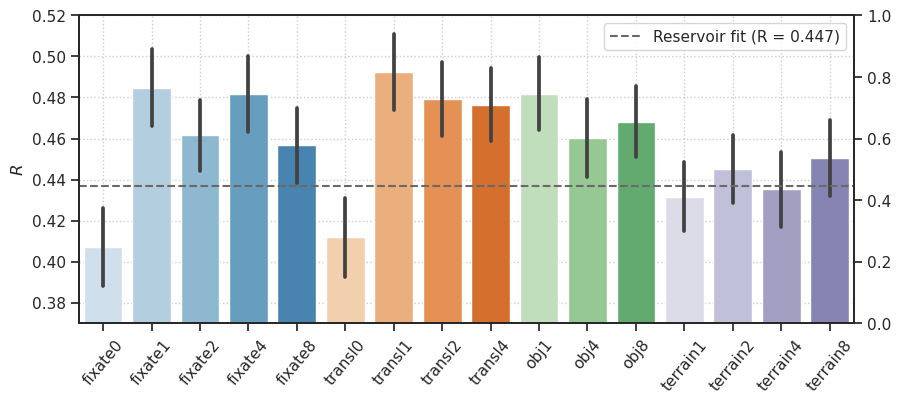

In [21]:
# HIDE CODE


fig, ax = create_figure(1, 1, (10, 4))
sns.barplot(
    data=df,
    x='category',
    y='perf',
    hue='category',
    palette=pal,
    errorbar='se',
    dodge=False,
    ax=ax,
)
ax.get_legend().remove()
ax.set(xlabel='', ylabel=r'$R$', ylim=(0.37, 0.52))
ax.tick_params(axis='x', rotation=50)
ax.grid()

axtwix = ax.twinx()
res_r = 0.447
axtwix.axhline(res_r, color='dimgrey', ls='--', label=f'Reservoir fit (R = {res_r})')
axtwix.legend()

plt.show()

## Get df best

In [76]:
df_best = best_results(df)

In [77]:
sorted_data = sorted(zip(
    df_best['perf_best'],
    df_best['perf_mu'],
    df_best['perf_sd'],
), key=lambda x: x[0])
sorted_data = list(map(
    lambda t: np.array(t),
    zip(*sorted_data),
))

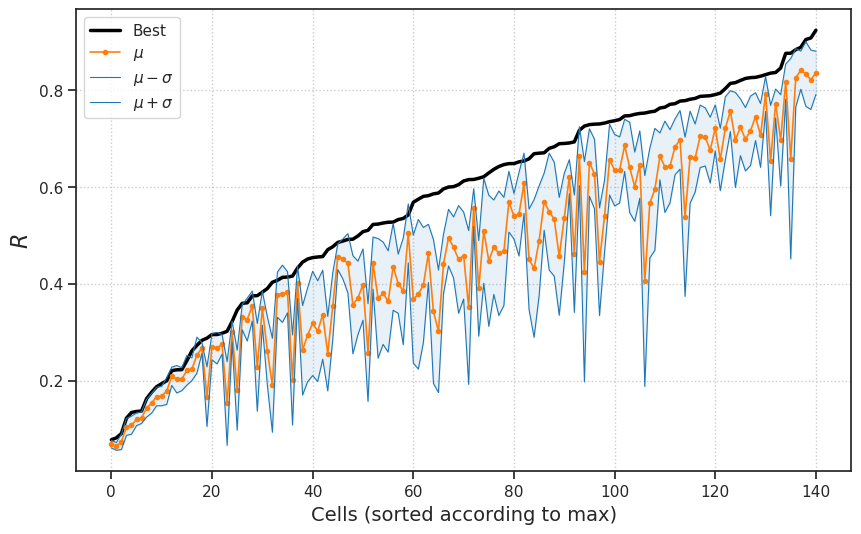

In [78]:
# HIDE CODE


fig, ax = create_figure(1, 1, (10, 6))
ax.plot(sorted_data[0], lw=2.5, color='k', label='Best')
ax.plot(sorted_data[1], lw=1.2, color='C1', marker='.', label=r'$\mu$')

lower = sorted_data[1] - sorted_data[2]
higher = sorted_data[1] + sorted_data[2]
ax.plot(lower, lw=0.8, color='C0', label=r'$\mu - \sigma$')
ax.plot(higher, lw=0.8, color='C0', label=r'$\mu + \sigma$')
ax.fill_between(
    x=range(len(df_best)),
    y1=lower,
    y2=higher,
    color='C0',
    alpha=0.1,
)
ax.set_xlabel('Cells (sorted according to max)', fontsize=14)
ax.set_ylabel(r'$R$', fontsize=16)
ax.legend()
ax.grid()
plt.show()

In [79]:
inds = df_best['perf_best'].argsort()[::-1]
df_best.iloc[inds[:20]]

,category,nf,root,expt,cell,max_perf,log_alpha,best_lag,perf_best,perf_worst,perf_mu,perf_sd,%+,%-
28,obj1,280,YUWEI,clu116,0,0.835483,16.0,0,0.923867,0.775911,0.835795,0.044743,10.537471,-7.164903
51,fixate8,420,YUWEI,clu221,3,0.900849,1.0,5,0.907961,0.673433,0.821540,0.061376,10.519356,-18.028029
124,fixate4,420,YUWEI,ytu029,4,0.935583,-8.0,3,0.904700,0.626719,0.833401,0.066842,8.555122,-24.799876
42,obj4,280,YUWEI,clu209,1,0.923722,8.0,5,0.888635,0.734939,0.841380,0.039539,5.616330,-12.650734
29,transl4,420,YUWEI,clu120,0,0.967720,3.0,3,0.883813,0.689495,0.825567,0.060198,7.055267,-16.482183
72,transl1,420,YUWEI,clu267,7,0.955361,2.0,5,0.876347,0.196418,0.658305,0.207112,33.121789,-70.163001
69,transl1,420,YUWEI,clu267,4,0.979806,2.0,5,0.876143,0.754572,0.817686,0.036552,7.149049,-7.718602
23,fixate1,420,YUWEI,clu104,0,0.980831,0.0,4,0.845799,0.452378,0.696512,0.094309,21.433555,-35.050855
109,terrain8,420,YUWEI,clu295,4,0.929612,5.0,5,0.836597,0.708316,0.772484,0.029892,8.299607,-8.306712
75,fixate1,420,YUWEI,clu267,11,0.850368,-10.0,6,0.835265,0.478776,0.654688,0.113925,27.582144,-26.869576


### Pie chart

In [80]:
labels, vals = zip(*collections.Counter(
    df_best['category']).most_common())
vals = [100 * e / sum(vals) for e in vals]

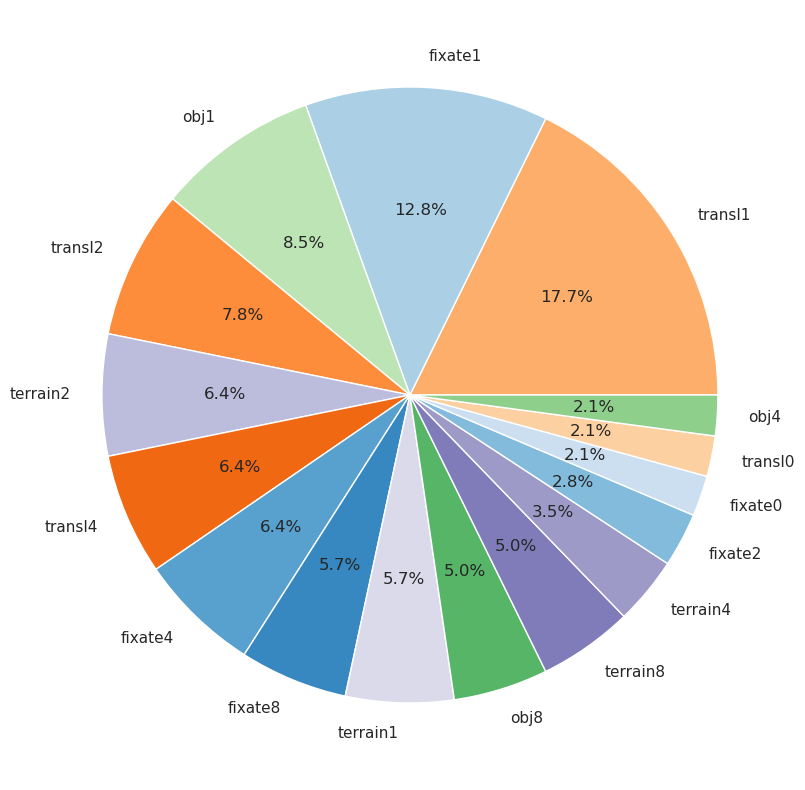

In [81]:
fig, ax = create_figure(1, 1, (11, 10))
ax.pie(
    x=vals,
    labels=labels,
    colors=[pal[e] for e in labels],
    autopct='%0.1f%%',
)
plt.show()

### Summary of results

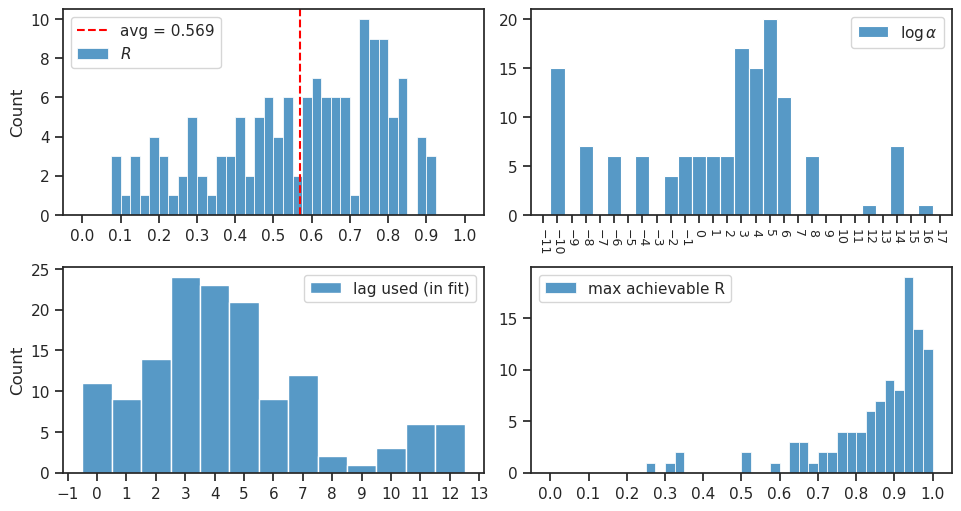

In [82]:
show_neural_results(df_best, 'perf_best');

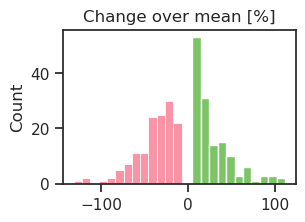

In [83]:
_pal = sns.color_palette('husl')
_pal = {'+': _pal[2], '-': _pal[0]}

fig, ax = create_figure(1, 1, (3, 2))
sns.histplot(df_best['%+'], color=_pal['+'], ax=ax)
sns.histplot(df_best['%-'], color=_pal['-'], ax=ax)
ax.set(xlabel='', title='Change over mean [%]')
plt.show()

In [84]:
val = np.concatenate([df_best['%+'].values, df_best['%-'].values])
label = ['+'] * len(df_best['%+']) + ['-'] * len(df_best['%-'])

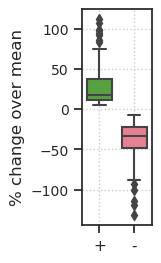

In [85]:
fig, ax = create_figure(1, 1, (0.9, 2.8))

sns.boxplot(
    data=pd.DataFrame({'val': val, 'label': label}),
    y='val',
    x='label',
    palette=_pal,
    width=0.70,
    ax=ax,
)
ax.tick_params(axis='y', labelsize=10)
ax.set(xlabel='', ylabel='% change over mean')
ax.grid()
plt.show()

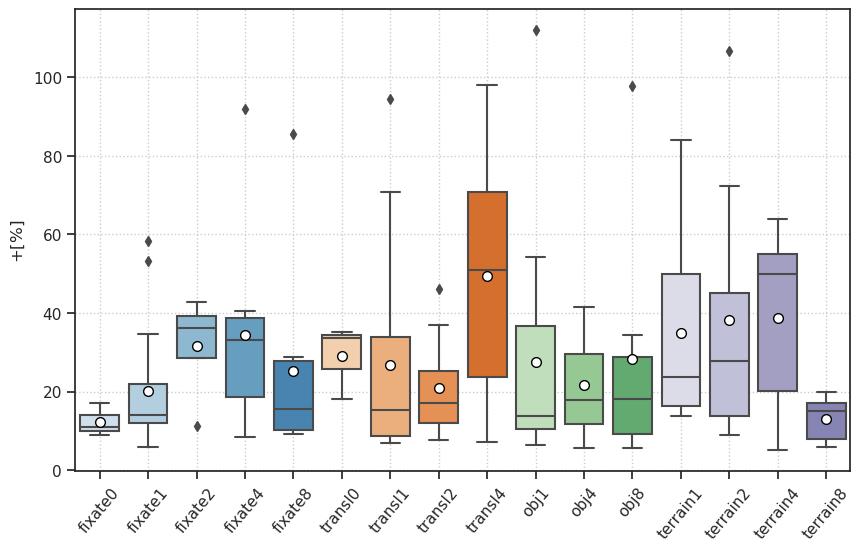

In [86]:
# HIDE CODE


props_mean = {
    'marker': 'o',
    'markerfacecolor': 'white',
    'markeredgecolor': 'k',
    'markersize': 7,
    'alpha': 1.0,
}

fig, ax = create_figure(1, 1, (10, 6))
sns.boxplot(
    data=df_best,
    y='%+',
    x='category',
    hue='category',
    order=pal,
    palette=pal,
    dodge=False,
    showmeans=True,
    meanprops=props_mean,
    ax=ax,
)
ax.set(xlabel='', ylabel=r'$+ [\%]$')
ax.tick_params(axis='x', rotation=50)
ax.get_legend().remove()
ax.grid()
plt.show()

In [87]:
categories = list(df['category'].unique())
df_test = best_results(df, categories)
perf_best = df_test['perf_best'].mean()
perf_best

0.569295295245549

In [88]:
reduced_perf = {}
for cat in grouped_by_cat:
    _df = best_results(df, [e for e in categories if cat not in e])
    reduced_perf[cat] = _df['perf_best'].mean()
print(reduced_perf)

{
    'fixate': 0.5608619058405487,
    'transl': 0.5573583165288217,
    'obj': 0.5662952427819891,
    'terrain': 0.560107695854514
}

In [89]:
reduced_perf_objs = {}
for n_obj in grouped_by_nobj:
    _df = best_results(df, [e for e in categories if int(e[-1]) == n_obj])
    reduced_perf_objs[n_obj] = _df['perf_best'].mean()
print(reduced_perf_objs)

{
    0: 0.44796809884141836,
    1: 0.5385817509997273,
    2: 0.5165595054286123,
    4: 0.5300833150368105,
    8: 0.5072535410862685
}

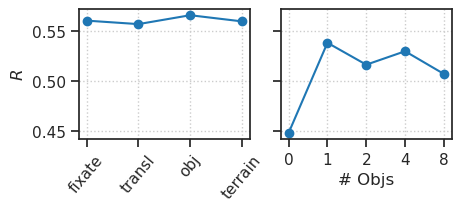

In [90]:
fig, axes = create_figure(1, 2, (4.5, 2), sharey='all', layout='constrained')

axes[0].plot(list(reduced_perf.values()), marker='o')
axes[0].set(xticks=range(len(reduced_perf)), xticklabels=list(reduced_perf), ylabel=r'$R$')
axes[0].tick_params(axis='x', rotation=50)
axes[0].grid()

axes[1].plot(list(reduced_perf_objs.values()), marker='o')
axes[1].set(xticks=range(len(reduced_perf_objs)), xticklabels=list(reduced_perf_objs), xlabel='# Objs')
axes[1].tick_params(axis='x', rotation=0)
axes[1].grid()

plt.show()

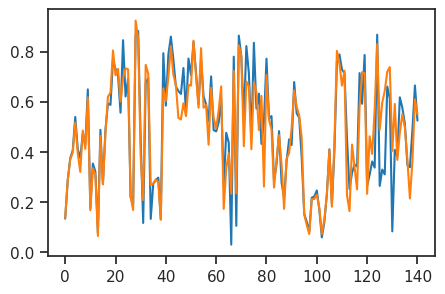

In [91]:
plt.plot(df.loc[df['category'] == 'fixate1', 'perf'].values)
plt.plot(df.loc[df['category'] == 'obj1', 'perf'].values)

## Permutation test

In [68]:
def statistic(a, b):
    return np.mean(a - b)


t = PrettyTable()
t.field_names = [
    'Category #1',
    'Category #2',
    'Statistic',
    'p-val',
    'Significant?',
]

looper = itertools.combinations(
    list(df['category'].unique()), 2)
for c1, c2 in looper:
    _data = (
        df.loc[df['category'] == c1, 'perf'].values,
        df.loc[df['category'] == c2, 'perf'].values,
    )
    test = sp_stats.permutation_test(
        data=_data,
        n_resamples=int(1e5),
        permutation_type='samples',
        alternative='two-sided',
        statistic=statistic,
        random_state=0,
    )
    t.add_row([
        c1,
        c2,
        np.round(test.statistic, 2),
        f"{test.pvalue:0.2g}",
        test.pvalue < 0.05,
    ])

In [69]:
print(t)

+-------------+-------------+-----------+---------+--------------+
| Category #1 | Category #2 | Statistic |  p-val  | Significant? |
+-------------+-------------+-----------+---------+--------------+
|   fixate0   |   fixate1   |   -0.08   |  2e-05  |     True     |
|   fixate0   |   fixate2   |   -0.05   |  2e-05  |     True     |
|   fixate0   |   fixate4   |   -0.07   |  2e-05  |     True     |
|   fixate0   |   fixate8   |   -0.05   |  2e-05  |     True     |
|   fixate0   |   transl0   |    -0.0   |   0.65  |    False     |
|   fixate0   |   transl1   |   -0.09   |  2e-05  |     True     |
|   fixate0   |   transl2   |   -0.07   |  2e-05  |     True     |
|   fixate0   |   transl4   |   -0.07   |  2e-05  |     True     |
|   fixate0   |     obj1    |   -0.07   |  2e-05  |     True     |
|   fixate0   |     obj4    |   -0.05   |  2e-05  |     True     |
|   fixate0   |     obj8    |   -0.06   |  2e-05  |     True     |
|   fixate0   |   terrain1  |   -0.02   |  0.023  |     True     |
|   fixate0   |   terrain2  |   -0.04   | 0.00046 |     True     |
|   fixate0   |   terrain4  |   -0.03   |  0.0034 |     True     |
|   fixate0   |   terrain8  |   -0.04   |  2e-05  |     True     |
|   fixate1   |   fixate2   |    0.02   |  0.0025 |     True     |
|   fixate1   |   fixate4   |    0.0    |   0.7   |    False     |
|   fixate1   |   fixate8   |    0.03   | 0.00052 |     True     |
|   fixate1   |   transl0   |    0.07   |  2e-05  |     True     |
|   fixate1   |   transl1   |   -0.01   |   0.25  |    False     |
|   fixate1   |   transl2   |    0.01   |   0.55  |    False     |
|   fixate1   |   transl4   |    0.01   |   0.33  |    False     |
|   fixate1   |     obj1    |    0.0    |   0.72  |    False     |
|   fixate1   |     obj4    |    0.02   |  0.0074 |     True     |
|   fixate1   |     obj8    |    0.02   |   0.04  |     True     |
|   fixate1   |   terrain1  |    0.05   |  2e-05  |     True     |
|   fixate1   |   terrain2  |    0.04   | 0.00016 |     True     |
|   fixate1   |   terrain4  |    0.05   |  2e-05  |     True     |
|   fixate1   |   terrain8  |    0.03   | 0.00086 |     True     |
|   fixate2   |   fixate4   |   -0.02   |  0.012  |     True     |
|   fixate2   |   fixate8   |    0.0    |   0.52  |    False     |
|   fixate2   |   transl0   |    0.05   |  6e-05  |     True     |
|   fixate2   |   transl1   |   -0.03   |  0.0004 |     True     |
|   fixate2   |   transl2   |   -0.02   |  0.015  |     True     |
|   fixate2   |   transl4   |   -0.02   |  0.057  |    False     |
|   fixate2   |     obj1    |   -0.02   |  0.0086 |     True     |
|   fixate2   |     obj4    |    0.0    |   0.9   |    False     |
|   fixate2   |     obj8    |   -0.01   |   0.37  |    False     |
|   fixate2   |   terrain1  |    0.03   |  0.0072 |     True     |
|   fixate2   |   terrain2  |    0.02   |   0.12  |    False     |
|   fixate2   |   terrain4  |    0.03   |   0.01  |     True     |
|   fixate2   |   terrain8  |    0.01   |   0.26  |    False     |
|   fixate4   |   fixate8   |    0.03   |  0.0021 |     True     |
|   fixate4   |   transl0   |    0.07   |  2e-05  |     True     |
|   fixate4   |   transl1   |   -0.01   |   0.17  |    False     |
|   fixate4   |   transl2   |    0.0    |   0.8   |    False     |
|   fixate4   |   transl4   |    0.01   |   0.58  |    False     |
|   fixate4   |     obj1    |    -0.0   |   0.98  |    False     |
|   fixate4   |     obj4    |    0.02   |  0.012  |     True     |
|   fixate4   |     obj8    |    0.01   |  0.096  |    False     |
|   fixate4   |   terrain1  |    0.05   |  4e-05  |     True     |
|   fixate4   |   terrain2  |    0.04   |  0.0011 |     True     |
|   fixate4   |   terrain4  |    0.05   |  2e-05  |     True     |
|   fixate4   |   terrain8  |    0.03   |  0.001  |     True     |
|   fixate8   |   transl0   |    0.04   | 0.00028 |     True     |
|   fixate8   |   transl1   |   -0.04   |  0.0002 |     True     |
|   fixate8   |   transl2   |   -0.02   |  0.00